#### Import thư viện

In [2]:
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os
import random
import numpy as np


#### Reading Training Image

In [12]:
BASE_DIR = "yalefaces"

person_folders = [
    "person-1", "person-2", "person-3", "person-4", "person-5",
    "person-6", "person-7", "person-8", "person-9", "person-10",
    "person-11", "person-12", "person-13", "person-14", "person-15"
]


- Resize ảnh về kích thước 1 × 64 × 80
- 1 là số channel (ảnh xám)
- Tất cả ảnh phải cùng size để PCA hoạt động

Suy ra:
- Mỗi ảnh được flatten thành vector dài 64×80 = 5120
- Mỗi người có: (10 ảnh, 5120 pixel)

In [13]:
data = {}

for person_folder in person_folders:
    for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
        image = imread(os.path.join(BASE_DIR, person_folder, filename))
        image = resize(image, (1, 64, 80), anti_aliasing=True)

        if person_folder not in data:
            data[person_folder] = [image]
        else:
            data[person_folder].append(image)


In [14]:
for person in data:
    data[person] = np.concat(data[person], axis=0).reshape(10, -1)


#### Standardizing images

- PCA rất nhạy với scale
- Chuẩn hóa giúp:
    + Mean = 0
    + Std = 1
- Tránh việc pixel sáng/tối chi phối PCA

In [15]:
def standardizing(images: np.ndarray) -> np.ndarray:
    images = (images - images.mean()) / images.std()
    images = images.astype(np.float32)
    return images


### Face Detection using PCA

Using PCA mechanism to correctly assign the face images to persons on the [Yale Face Dataset](https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/). Download the training data and testing data in this link.

#### Assignment 1 (4 scores): Implement PCA using Numpy.

#### PCA implementation

**1. Ma trận hiệp phương sai**
- X: (150 ảnh, 5120 pixel)
    - X.T @ X: (5120 × 5120)
    - Đây là covariance matrix (bỏ hệ số 1/N)
- Ma trận này mô tả mối tương quan giữa các pixel

**2. Eigenvalues & Eigenvectors**
- eigenvector: hướng biến thiên
- eigenvalue: mức độ quan trọng của hướng đó
-> Eigenvectors chính là Eigenfaces

3. Sắp xếp theo độ quan trọng
`eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)`
- Giữ lại 20 eigenvectors có eigenvalue lớn nhất
- Chúng biểu diễn thông tin khuôn mặt quan trọng nhất

In [16]:
class PrincipleComponentAnalysis:
    def __init__(self, d_principle: int = 1):
        self.d_principle = d_principle
    
    def fit(self, X: np.ndarray):
        cov = (X.T @ X)

        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # change the sign of the maximum absolute value to positive
        max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
        signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
        eigenvectors = eigenvectors * signs[np.newaxis, :]
        eigenvectors = eigenvectors.T  # (num vectors, dim)

        # rearrange eigenvectors and eigenvalues
        eigen_pairs = [
            (np.abs(eigenvalues[i]), eigenvectors[i, :])
            for i in range(eigenvectors.shape[0])
        ]

        # sort descending
        eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)

        eigenvalues = np.array([value for value, _ in eigen_pairs])
        eigenvectors = np.array([vector for _, vector in eigen_pairs])

        # select principal components
        self.principle_values = eigenvalues[:self.d_principle]
        self._W = eigenvectors[:self.d_principle]

    def transform(self, X: np.ndarray) -> np.ndarray:
        X_hat = self._W @ X
        return X_hat



#### Visualize random person images

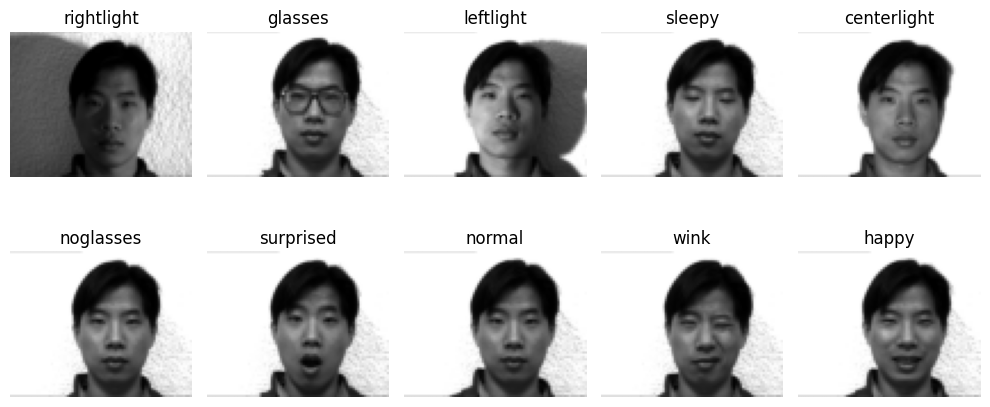

In [17]:
person_folder = random.choice(person_folders)

plt.figure(figsize=(10, 5))
for ith, filename in enumerate(os.listdir(os.path.join(BASE_DIR, person_folder))):
    image = imread(os.path.join(BASE_DIR, person_folder, filename))
    image = image.squeeze(0)
    image = resize(image, (64, 80), anti_aliasing=True)

    plt.subplot(2, 5, ith + 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title(filename)

plt.tight_layout()
plt.show()


#### Prepare training matrix

In [18]:
images = []
for person in data:
    images.append(data[person])

images = np.concat(images, axis=0)
images = standardizing(images)
images.shape


(150, 5120)

- `d_principle`: số chiều không gian mới (ở đây = 20)

In [19]:
PCA = PrincipleComponentAnalysis(d_principle=20)
PCA.fit(images)

In [20]:
PCA._W.shape

(20, 5120)

#### Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.

#### Visualize Eigenfaces

**1. Eigenface là gì?**
- Là “khuôn mặt trung bình + biến thiên”
- Mỗi eigenface thể hiện:
    - ánh sáng
    - viền mặt
    - vùng mắt, mũi, miệng
- PCA không học người, nó học pattern chung của khuôn mặt

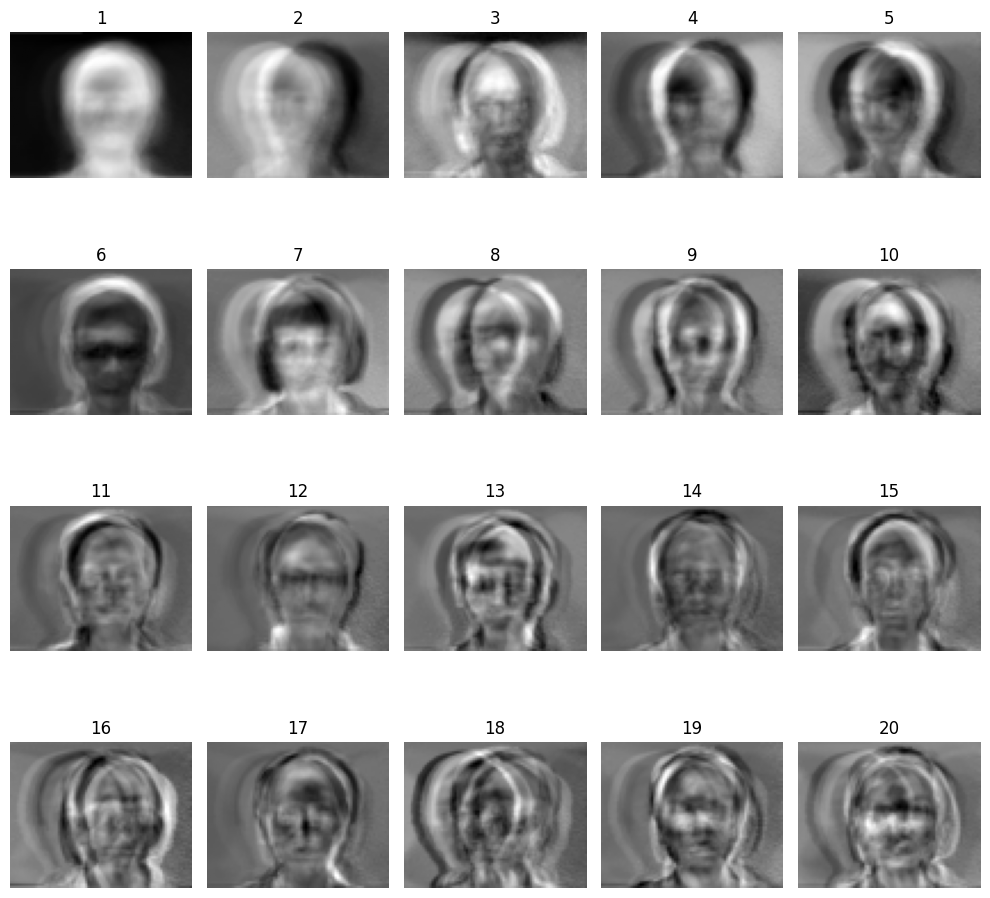

In [21]:
eigenfaces = PCA._W
eigenfaces = eigenfaces.reshape(20, 64, 80)

plt.figure(figsize=(10, 10))
for ith, eigenface in enumerate(eigenfaces):
    plt.subplot(4, 5, ith + 1)
    plt.imshow(eigenface, cmap="gray")
    plt.axis("off")
    plt.title(ith + 1)

plt.tight_layout()
plt.show()


#### Project mean faces

- Mỗi người → 1 vector đại diện
- Dùng mean face để so sánh

In [22]:
mean_faces = {}
for person in data:
    mean_faces[person] = np.mean(data[person], axis=0)

projected_mean_faces = {}
for person in mean_faces:
    mean_face = mean_faces[person]
    projected_mean_faces[person] = PCA.transform(mean_face)


#### Assignment 3 (2 scores): 
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

#### Load test data

In [24]:
labels = []
test_images = []

TEST_DIR = "yalefaces/test"

for filename in os.listdir(os.path.join(TEST_DIR)):
    person_name = filename.split(".")[0]
    labels.append(person_name)

    image = imread(os.path.join(TEST_DIR, filename))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    test_images.append(image)


In [25]:
test_images = np.concat(test_images, axis=0)
test_images.shape


(15, 64, 80)

In [26]:
labels


['person-5',
 'person-15',
 'person-7',
 'person-14',
 'person-13',
 'person-12',
 'person-6',
 'person-9',
 'person-4',
 'person-10',
 'person-11',
 'person-1',
 'person-3',
 'person-2',
 'person-8']

#### Euclidean distance

Đo độ giống nhau giữa:
- Ảnh test
- Mean face của từng người

-> Khoảng cách nhỏ nhất → người giống nhất

In [ ]:
def Euclide_distance(X: np.ndarray, Y: np.ndarray):
    assert X.shape == Y.shape, f"{X.__str__()} and {Y.__str__()} are miss-shaped"
    return ((X - Y) ** 2).sum() ** 0.5

#### Face recognition & evaluation

Quy trình:
- Chiếu ảnh test → PCA
- So với mean PCA của từng người
- Chọn người có distance nhỏ nhất

In [28]:
predictions = {}

for label, image in zip(labels, test_images):
    image = image.reshape(-1)
    projected_face = PCA.transform(image)

    closest_distance = np.inf
    closest_person = None

    for person in projected_mean_faces:
        mean_face = projected_mean_faces[person]
        distance = Euclide_distance(mean_face, projected_face)

        if distance < closest_distance:
            closest_distance = distance
            closest_person = person

    predictions[label] = closest_person


In [29]:
EMs = []
for label in predictions:
    EMs.append(label == predictions[label])


In [30]:
print(f"Accuracy: {(np.mean(EMs) * 100):.2f}%")


Accuracy: 66.67%
